# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, make_scorer
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [63]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [64]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

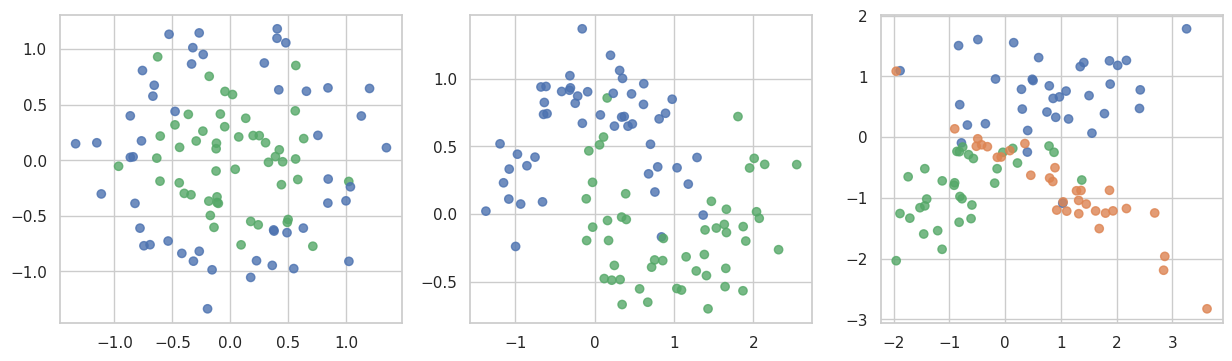

In [65]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [66]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

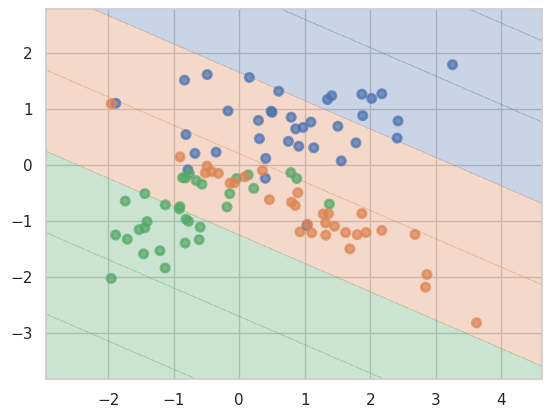

In [67]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Dataset 1:
Train accuracy: 1.000
Test accuracy: 0.733

Dataset 2:
Train accuracy: 1.000
Test accuracy: 0.867

Dataset 3:
Train accuracy: 1.000
Test accuracy: 0.833



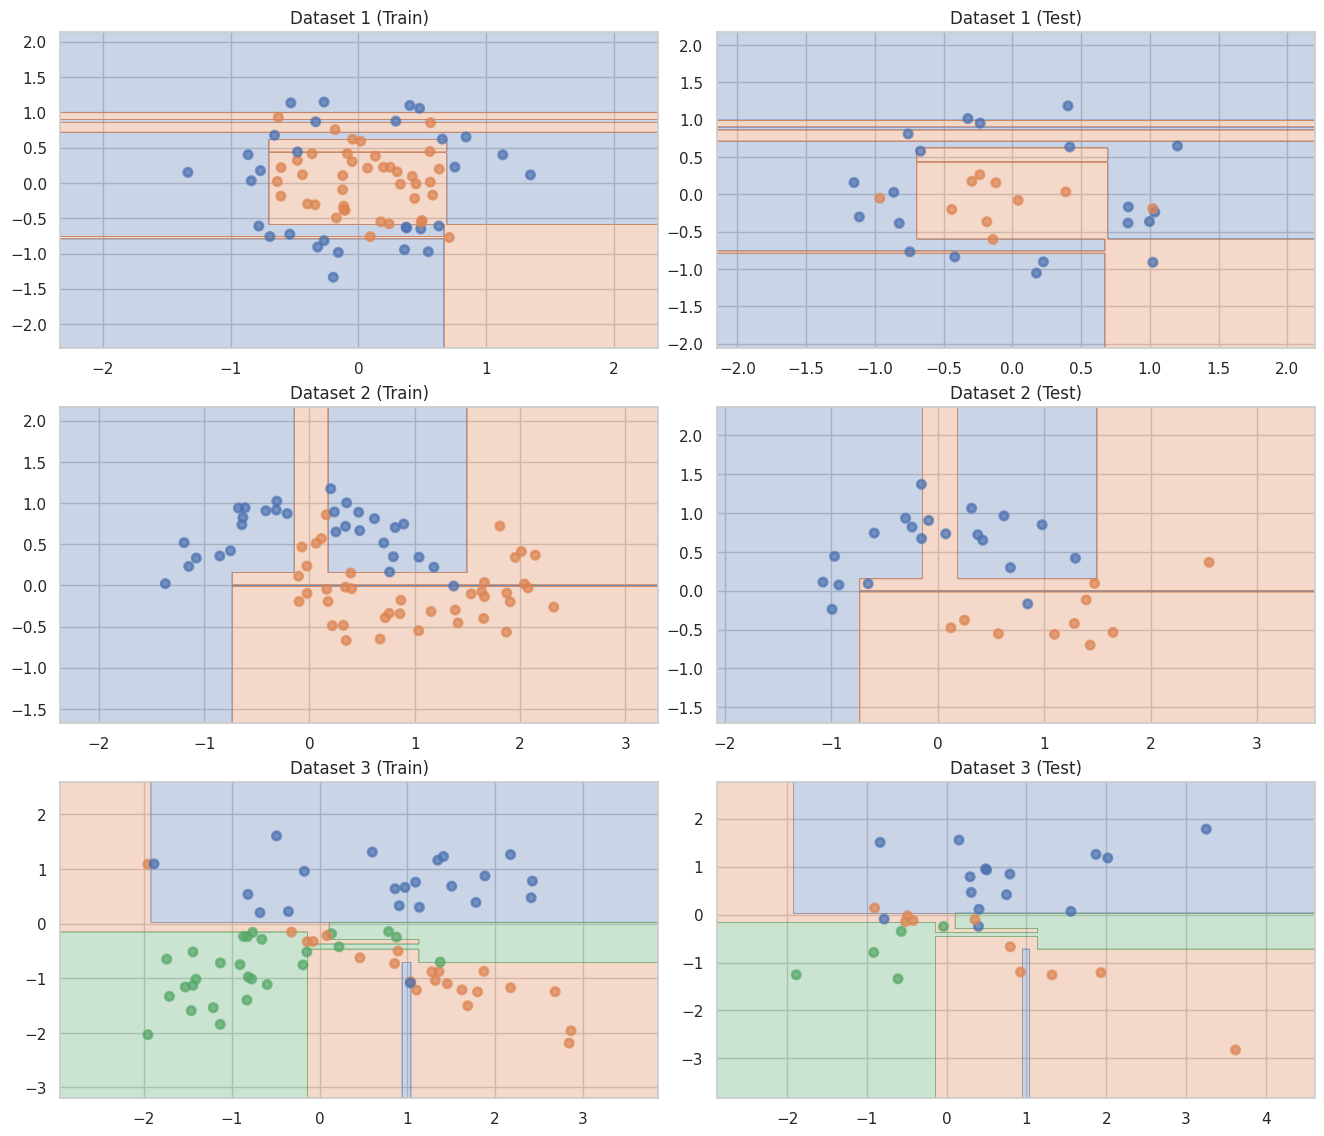

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

plt.figure(figsize=(14, 12))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    plt.subplot(3, 2, 2 * i + 1)
    plot_surface(clf, X_train, y_train)
    plt.title(f'Dataset {i + 1} (Train)')

    plt.subplot(3, 2, 2 * i + 2)
    plot_surface(clf, X_test, y_test)
    plt.title(f'Dataset {i + 1} (Test)')

    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))

    print(f'Dataset {i + 1}:')
    print(f'Train accuracy: {train_acc:.3f}')
    print(f'Test accuracy: {test_acc:.3f}\n')

__Ответ:__ Наблюдается выраженное переобучение решающих деревьев с дефолтными параметрами. При достижении максимальной accuracy 1.0 на тренировочной выборке, производительность на тестовых данных существенно ниже: 0.733 (датасет 1), 0.867 (датасет 2), 0.833 (датасет 3).

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?


Dataset: 1


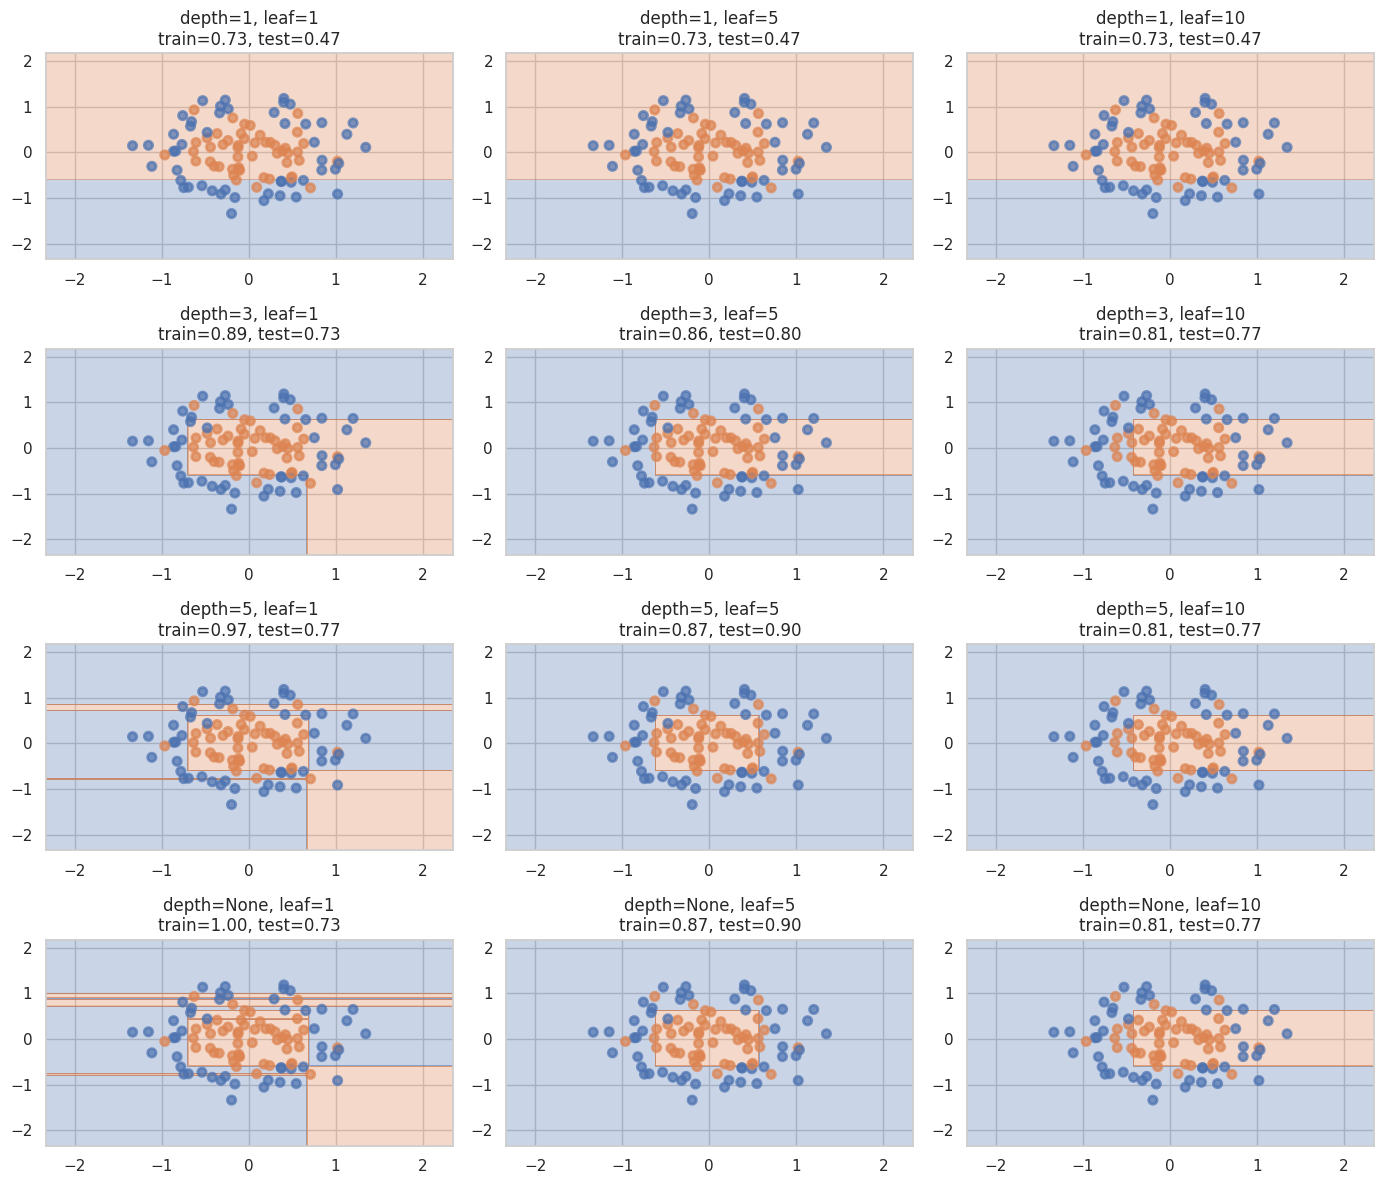


Dataset: 2


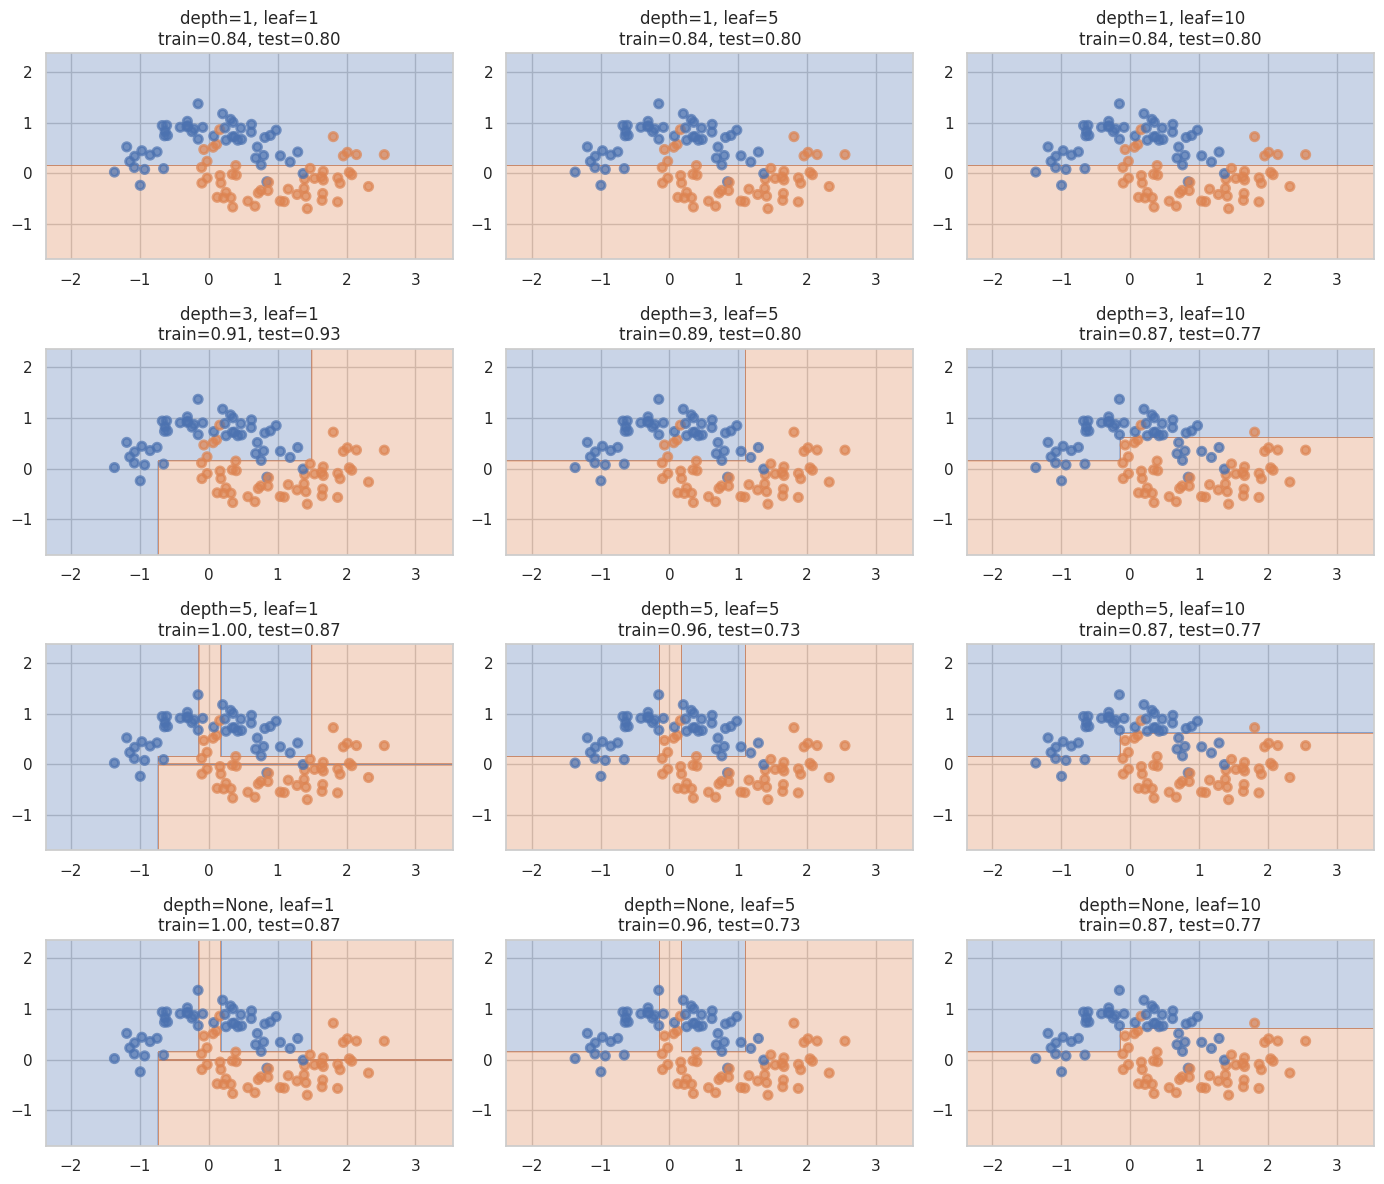


Dataset: 3


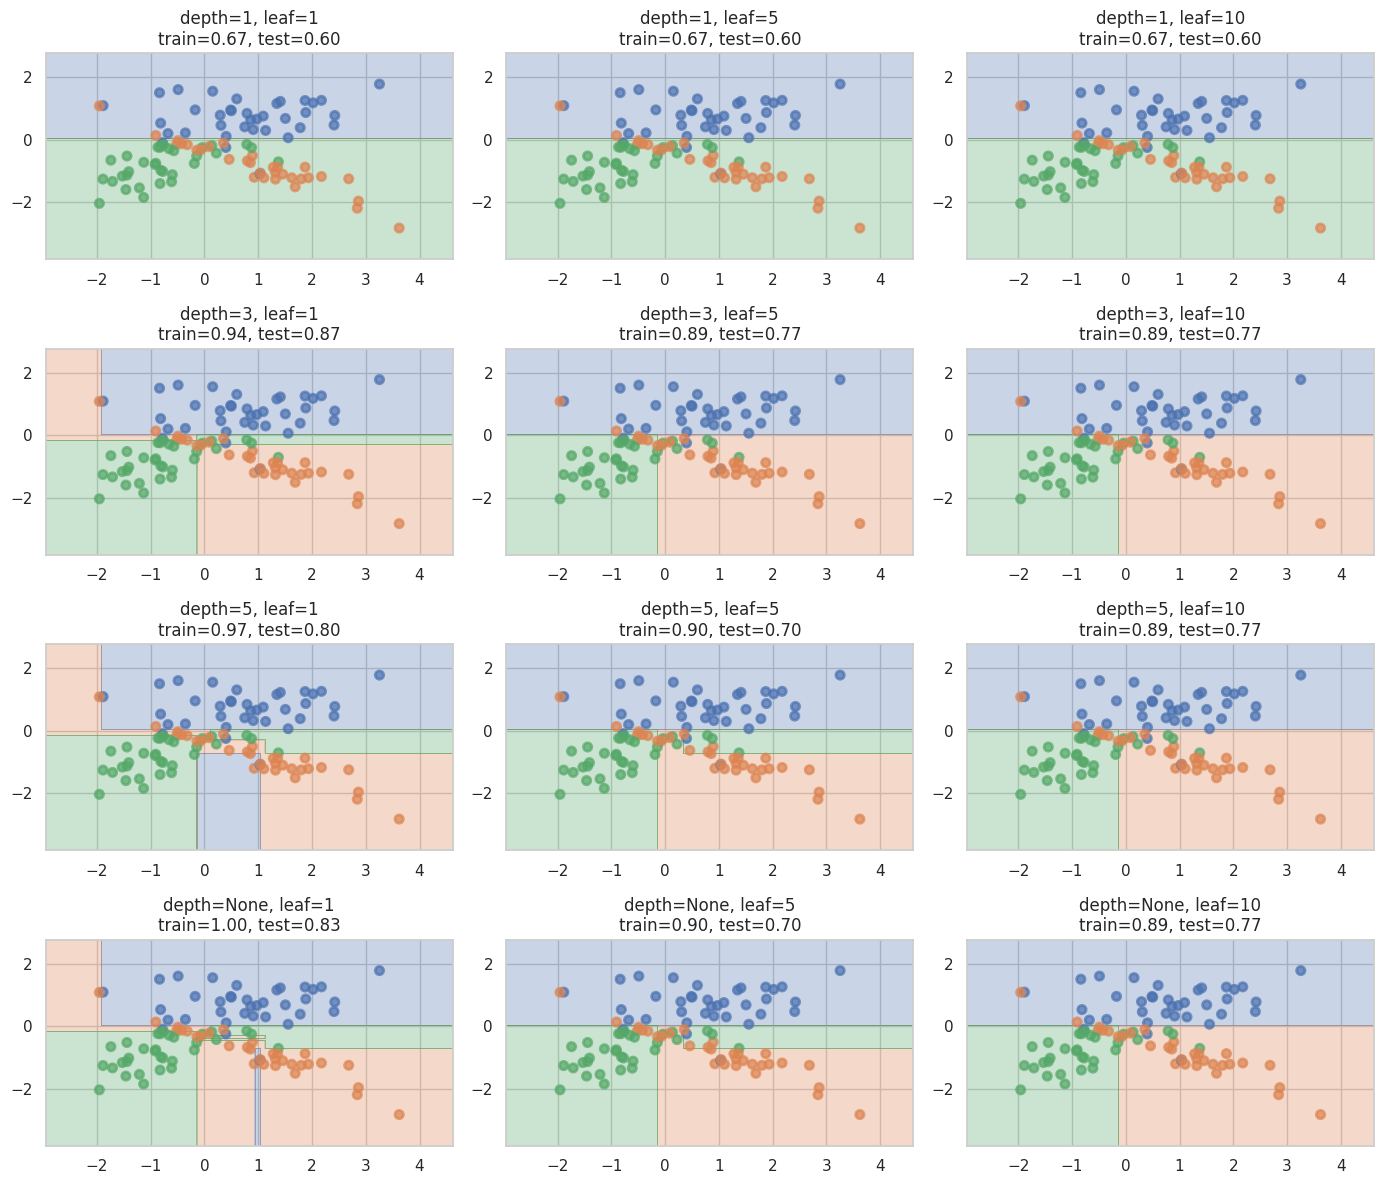

In [69]:
depths = [1, 3, 5, None]
min_leaves = [1, 5, 10]

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print(f"\nDataset: {i + 1}")

    plt.figure(figsize=(14, 12))
    plot_num = 1

    for depth in depths:
        for leaf in min_leaves:
            clf = DecisionTreeClassifier(max_depth=depth,
                                         min_samples_leaf=leaf,
                                         random_state=42)
            clf.fit(X_train, y_train)

            train_acc = accuracy_score(y_train, clf.predict(X_train))
            test_acc = accuracy_score(y_test, clf.predict(X_test))

            plt.subplot(len(depths), len(min_leaves), plot_num)
            plot_surface(clf, X, y)
            plt.title(f"depth={depth}, leaf={leaf}\ntrain={train_acc:.2f}, test={test_acc:.2f}")
            plot_num += 1

    plt.tight_layout()
    plt.show()

__Ответ:__ По глубине дерева:

При малой глубине (например, 1) — модель слишком простая, возникает недообучение

При средней глубине (3-5) — оптимальный баланс между обучением и переобучением

Без ограничений глубины (None) — модель становится излишне сложной и переобучается

По минимальному размеру листа:

При маленьких значениях (1) — модель может подстраиваться под шум в данных

При увеличении значений (5-10) — улучшается способность к обобщению

Результаты по датасетам:

Dataset 1: Наилучший результат (90%) достигнут при max_depth=5 и min_samples_leaf=5 и при max_depth=None и min_samples_leaf=5. Модель показала высокую чувствительность к настройкам параметров.

Dataset 2: Оптимальная конфигурация (max_depth=3, min_samples_leaf=1) дала точность 93%. Увеличение глубины дерева приводит к переобучению.

Dataset 3: Лучший результат (87%) получен при max_depth=3 и min_samples_leaf=1. Модель продемонстрировала меньшую чувствительность к параметрам по сравнению с другими датасетами.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

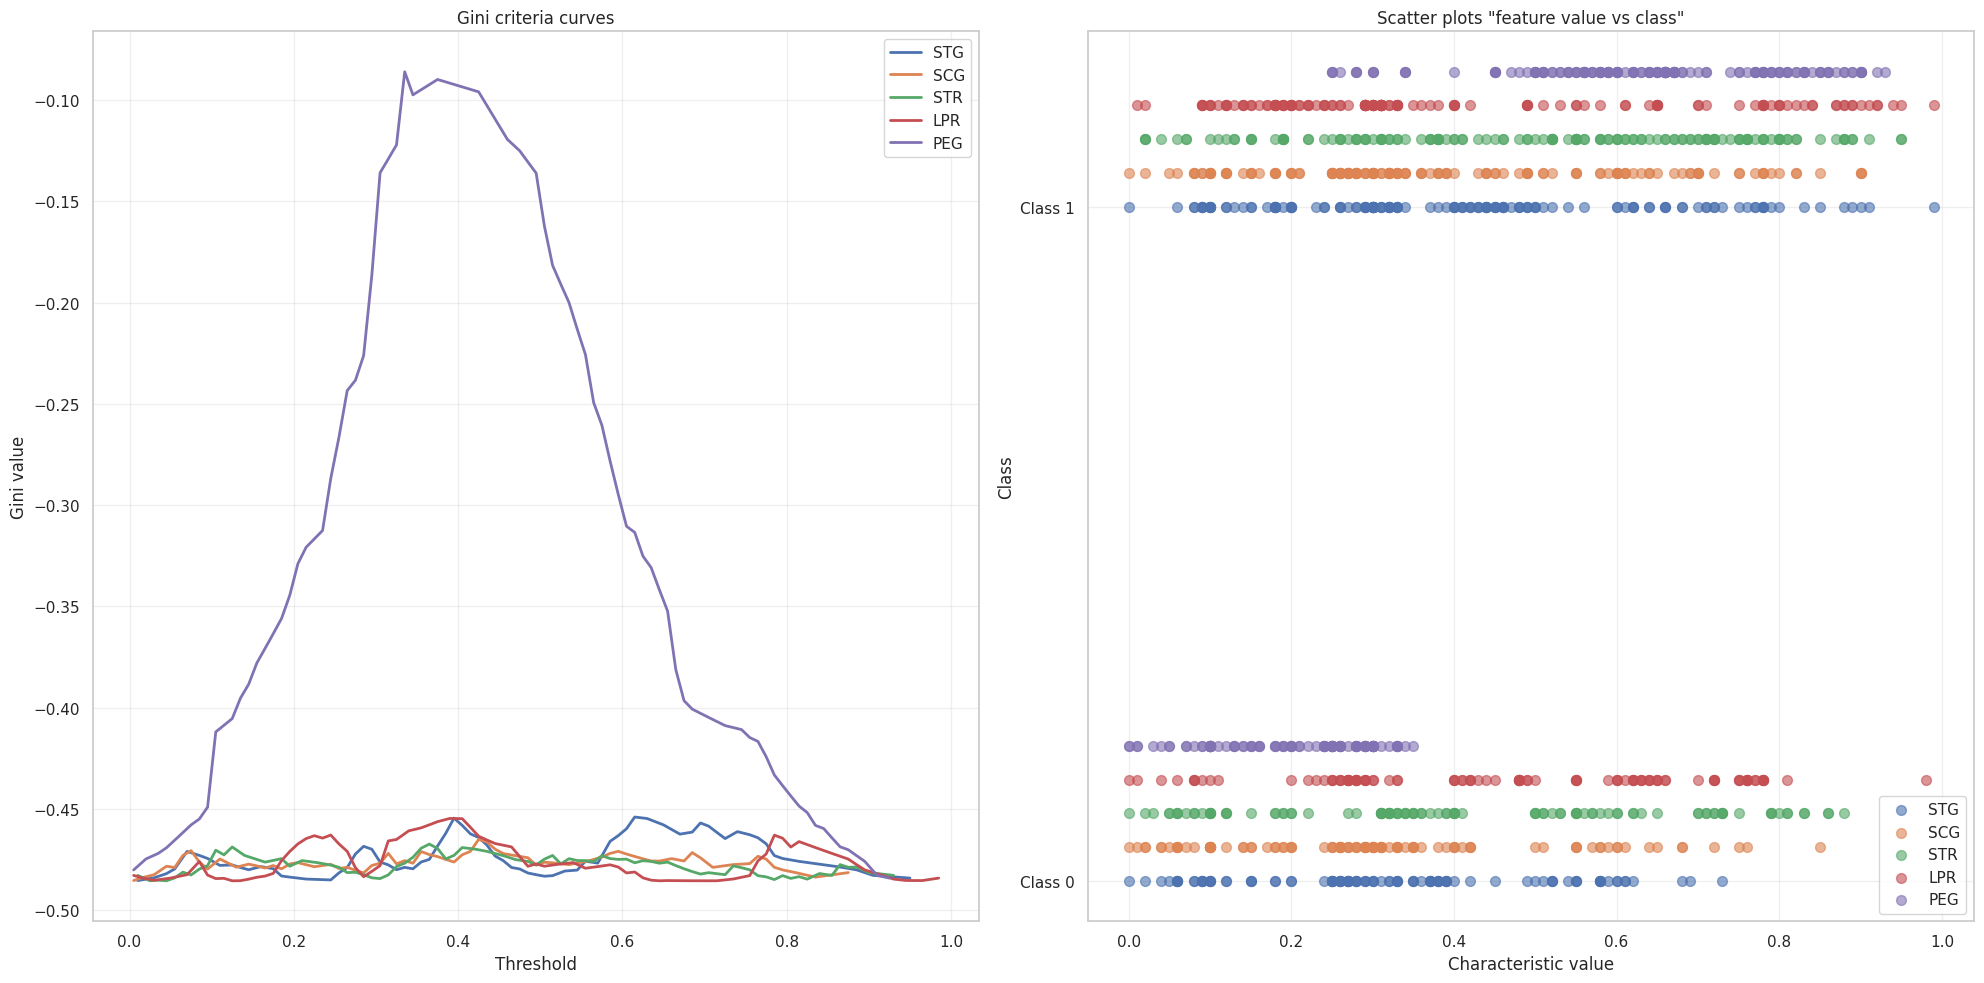

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

data = pd.read_csv('students.csv')
features = data.iloc[:, :5]
target = data.iloc[:, 5]

def find_best_split(feature_vector, target_vector):
    sorted_idx = np.argsort(feature_vector)
    sorted_feature = feature_vector[sorted_idx]
    sorted_target = target_vector[sorted_idx]

    thresholds = (sorted_feature[1:] + sorted_feature[:-1]) / 2
    unique_thresh_idx = np.where(np.diff(sorted_feature) != 0)[0]
    thresholds = thresholds[unique_thresh_idx]

    if len(thresholds) == 0:
        return None, None, None, None

    left_cumsum = np.cumsum(sorted_target[:-1])[unique_thresh_idx]
    left_total = np.arange(1, len(sorted_feature))[unique_thresh_idx]
    left_p1 = left_cumsum / left_total
    left_p0 = 1 - left_p1

    right_cumsum = np.sum(sorted_target) - left_cumsum
    right_total = len(sorted_feature) - left_total
    right_p1 = right_cumsum / right_total
    right_p0 = 1 - right_p1

    H_left = 1 - left_p0 ** 2 - left_p1 ** 2
    H_right = 1 - right_p0 ** 2 - right_p1 ** 2
    gini_gain = -(left_total / len(sorted_feature)) * H_left - (right_total / len(sorted_feature)) * H_right

    best_idx = np.argmax(gini_gain)
    return thresholds, gini_gain, thresholds[best_idx], gini_gain[best_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

for col in features.columns:
    thresholds, gini_values, best_thresh, best_gini = find_best_split(
        features[col].values, target.values
    )
    if thresholds is not None:
        ax1.plot(thresholds, gini_values, label=f'{col}', linewidth=2)

ax1.set_xlabel('Threshold')
ax1.set_ylabel('Gini value')
ax1.set_title('Gini criteria curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

for i, col in enumerate(features.columns):
    ax2.scatter(features[col], target + i*0.05,
               label=f'{col}', alpha=0.6, s=50)

ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Class 0', 'Class 1'])
ax2.set_xlabel('Characteristic value')
ax2.set_ylabel('Class')
ax2.set_title('Scatter plots "feature value vs class"')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Анализ графиков критерия Джини показывает, что выборку лучше всего разделять по признакам с самыми высокими пиками на графике. Когда значение Джини приближается к 0.5, это означает, что признак хорошо разделяет классы при определенном пороге.

На scatter-графиках это хорошо видно: у "сильных" признаков классы четко отделены друг от друга, а их кривые Джини имеют выраженные пики. Это говорит о том, что существует конкретный порог, при котором разделение получается наиболее эффективным.

В то же время, признаки с почти плоскими кривыми Джини (со значениями близкими к нулю) плохо подходят для разделения. Классы по таким признакам сильно перемешаны, и найти хороший порог для их разделения практически невозможно.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [71]:
import sys
sys.path.append('/content')
from hw2 import DecisionTree
import pandas as pd

df = pd.read_csv('agaricus-lepiota.data', header=None)

label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

target_col = 0
y = df.iloc[:, target_col].values
X = df.iloc[:, 1:].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

feature_types = ['categorical'] * (X.shape[1])
tree = DecisionTree(feature_types=feature_types, max_depth=None)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy: {accuracy:.3f}")

def get_tree_depth(node):
    if node.get("type") == "terminal":
        return 0
    left_depth = get_tree_depth(node["left_child"])
    right_depth = get_tree_depth(node["right_child"])
    return 1 + max(left_depth, right_depth)

depth = get_tree_depth(tree._tree)
print(f"Depth: {depth}")

Model accuracy: 1.000
Depth: 7


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

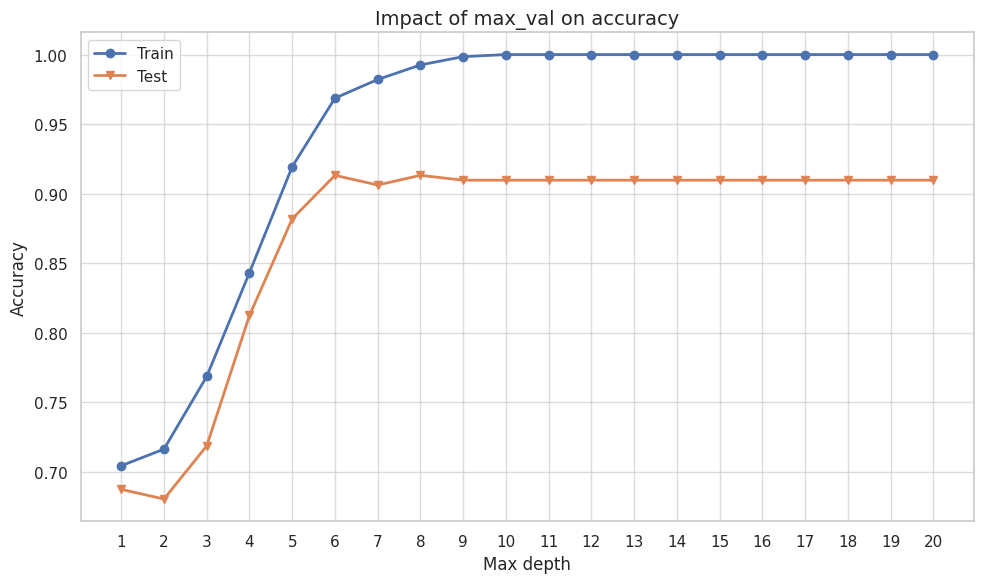

In [72]:
df = pd.read_csv('tic-tac-toe-endgame.csv')

X = df.drop(columns='V10')
y = (df['V10'] == 'positive').astype(int).values

X_encoded = np.zeros(X.shape, dtype=int)
for i, column in enumerate(X.columns):
    encoder = LabelEncoder()
    X_encoded[:, i] = encoder.fit_transform(X[column])

feature_types = ['categorical'] * X_encoded.shape[1]
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

max_depths = range(1, 21)
train_accuracies = []
test_accuracies = []

for depth in max_depths:
    model = DecisionTree(
        feature_types=feature_types,
        max_depth=depth,
        min_samples_split=2,
        min_samples_leaf=1
    )
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_accuracies.append(accuracy_score(y_train, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Train', marker='o', linewidth=2)
plt.plot(max_depths, test_accuracies, label='Test', marker='v', linewidth=2)
plt.title('Impact of max_val on accuracy', fontsize=14)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.xticks(max_depths)
plt.grid(True, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

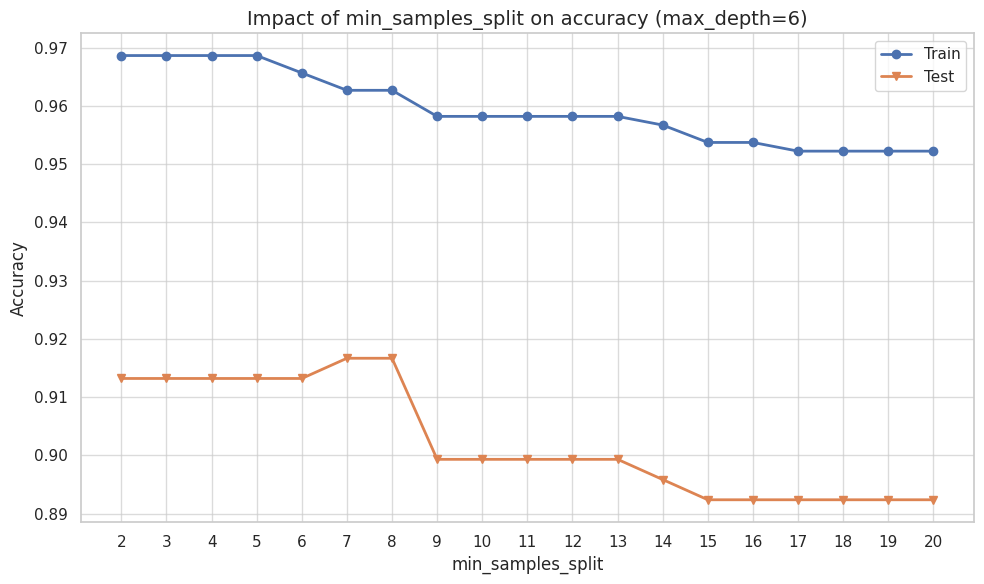

In [73]:
min_samples_values = range(2, 21)
train_accuracies = []
test_accuracies = []

for min_samples in min_samples_values:
    model = DecisionTree(
        feature_types=feature_types,
        max_depth=6,
        min_samples_split=min_samples,
        min_samples_leaf=1
    )
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_accuracies.append(accuracy_score(y_train, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(10, 6))
plt.plot(min_samples_values, train_accuracies, label='Train', marker='o', linewidth=2)
plt.plot(min_samples_values, test_accuracies, label='Test', marker='v', linewidth=2)
plt.title('Impact of min_samples_split on accuracy (max_depth=6)', fontsize=14)
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.xticks(min_samples_values)
plt.grid(True, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


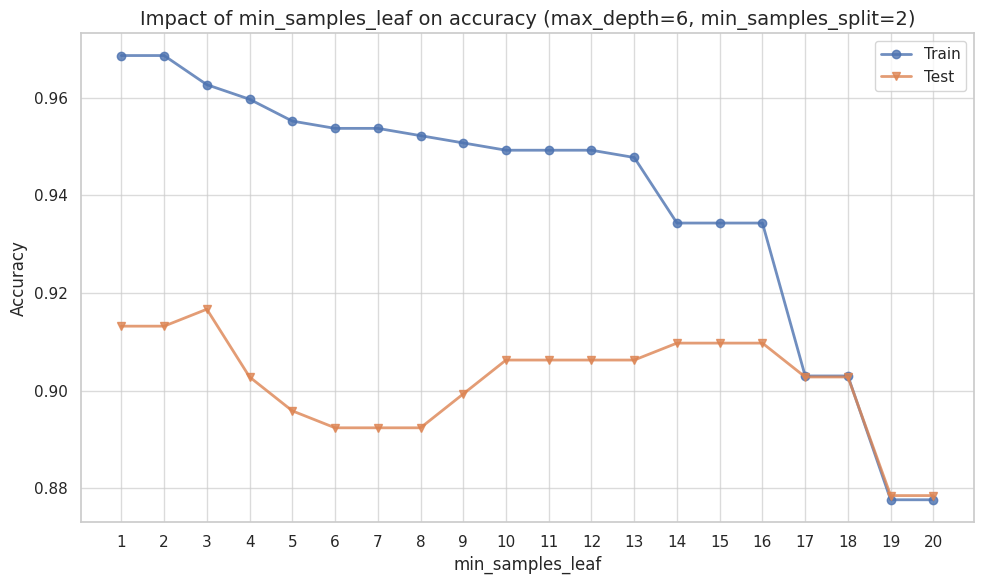

In [74]:
min_leaf_values = range(1, 21)
train_accuracies = []
test_accuracies = []

for min_leaf in min_leaf_values:
    model = DecisionTree(
        feature_types=feature_types,
        max_depth=6,
        min_samples_split=2,
        min_samples_leaf=min_leaf
    )
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_accuracies.append(accuracy_score(y_train, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(10, 6))
plt.plot(min_leaf_values, train_accuracies, label='Train', marker='o', linewidth=2, alpha=0.8)
plt.plot(min_leaf_values, test_accuracies, label='Test', marker='v', linewidth=2, alpha=0.8)
plt.title('Impact of min_samples_leaf on accuracy (max_depth=6, min_samples_split=2)', fontsize=14)
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.xticks(min_leaf_values)
plt.grid(True, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [75]:
class CustomDecisionTree:
    def __init__(self, feature_types):
        self.feature_types = feature_types
        self.model = DecisionTreeClassifier()

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)


class ContinuousTreeWrapper:
    def __init__(self):
        self.tree = None

    def fit(self, X, y):
        self.tree = CustomDecisionTree(['continuous'] * X.shape[1])
        data = X.values if hasattr(X, 'values') else X
        self.tree.fit(data.astype(float), y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        data = X.values if hasattr(X, 'values') else X
        return self.tree.predict(data.astype(float))

    def get_params(self, deep=True):
        return {}


class CategoricalTreeWrapper:
    def __init__(self):
        self.tree = None

    def fit(self, X, y):
        self.tree = CustomDecisionTree(['categorical'] * X.shape[1])
        data = X.values if hasattr(X, 'values') else X
        self.tree.fit(data, y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        data = X.values if hasattr(X, 'values') else X
        return self.tree.predict(data)

    def get_params(self, deep=True):
        return {}


class OneHotTreeWrapper:
    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.tree = None

    def fit(self, X, y):
        data = X.values if hasattr(X, 'values') else X
        self.encoder.fit(data)
        transformed = self.encoder.transform(data)
        self.tree = CustomDecisionTree(['continuous'] * transformed.shape[1])
        self.tree.fit(transformed, y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        data = X.values if hasattr(X, 'values') else X
        transformed = self.encoder.transform(data)
        return self.tree.predict(transformed)

    def get_params(self, deep=True):
        return {}


def load_and_prepare_data():
    mushroom_data = pd.read_csv('agaricus-lepiota.data', header=None)
    tic_data = pd.read_csv('tic-tac-toe-endgame.csv')
    car_data = pd.read_csv(
        'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
        header=None
    )
    nursery_data = pd.read_csv(
        'https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data',
        header=None
    )

    tic_target = tic_data.columns[-1]
    car_target = car_data.columns[-1]
    nursery_target = nursery_data.columns[-1]

    mushroom_data[0] = mushroom_data[0].map({'p': 0, 'e': 1})
    tic_data[tic_target] = tic_data[tic_target].map({'negative': 0, 'positive': 1})
    car_data[car_target] = car_data[car_target].map({
        'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1
    })
    nursery_data[nursery_target] = nursery_data[nursery_target].map({
        'not_recom': 0, 'recommend': 0, 'very_recom': 1,
        'priority': 1, 'spec_prior': 1
    })

    datasets = {
        'Mushrooms': (mushroom_data, 0),
        'TicTacToe': (tic_data, tic_target),
        'Cars': (car_data, car_target),
        'Nursery': (nursery_data, nursery_target)
    }

    label_encoder = LabelEncoder()
    for name, (df, target_col) in datasets.items():
        features = [col for col in df.columns if col != target_col]
        for feature_col in features:
            df[feature_col] = label_encoder.fit_transform(df[feature_col].astype(str))

    return datasets


def run_experiment():
    datasets = load_and_prepare_data()

    models = {
        'Continuous': ContinuousTreeWrapper(),
        'Categorical': CategoricalTreeWrapper(),
        'OneHot': OneHotTreeWrapper(),
        'Sklearn': DecisionTreeClassifier()
    }

    scorer = make_scorer(accuracy_score)
    results = []

    for dataset_name, (dataframe, target_column) in datasets.items():
        if isinstance(target_column, int) and target_column < 0:
            X = dataframe.iloc[:, :target_column]
            y = dataframe.iloc[:, target_column]
        else:
            X = dataframe.drop(columns=target_column)
            y = dataframe[target_column]

        dataset_scores = {'Dataset': dataset_name}

        for model_name, model in models.items():
            try:
                cv_scores = cross_val_score(model, X, y, cv=10, scoring=scorer)
                dataset_scores[model_name] = np.mean(cv_scores)
            except Exception as error:
                dataset_scores[model_name] = f"Error: {error}"

        results.append(dataset_scores)

    return pd.DataFrame(results).set_index('Dataset')


print("Comparison of models by accuracy\n")

results_df = run_experiment()
pd.options.display.float_format = '{:.4f}'.format

print(results_df)

Comparison of models by accuracy

           Continuous  Categorical  OneHot  Sklearn
Dataset                                            
Mushrooms      0.9993       0.9993  1.0000   0.9567
TicTacToe      0.4686       0.4718  0.5457   0.7842
Cars           0.9397       0.9351  0.9160   0.9433
Nursery        0.9997       0.9997  0.9997   0.9997


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Вставьте что угодно, описывающее ваши впечатления от этого задания:

В ходе эксперимента видно, что одни и те же алгоритмы показывают разную эффективность на разных наборах данных.

На примере Mushrooms и Nursery все деревья справляются практически идеально — точность близка к 100%. А вот с TicTacToe ситуация сложнее: здесь некоторые модели показывают слабые результаты, тогда как другие демонстрируют хорошее качество.

Основная причина кроется в типах признаков. В Mushrooms и Nursery признаки представляют собой простые категории, которые сами по себе хорошо разделяют данные — деревья легко находят правильные правила. В TicTacToe же важны комбинации нескольких признаков одновременно, и простое числовое кодирование здесь не справляется. One-hot кодирование лучше передает структуру данных, поэтому эта модель работает заметно лучше.

Также стоит учитывать, что в результатах присутствует некоторая случайность из-за разного разделения данных при кросс-валидации. Чтобы сделать оценку более стабильной, можно увеличить количество разбиений — это поможет уменьшить влияние случайных вариаций.